# Autoencoder

Set some global parameters

In [1]:
# Whether to rotate data in an orientation indiepndent manner.
# Default: True
USE_ORIENTATION_INDIPENDENT_TRANSFORMATION = True

# Whether to normalize data.
# Note: we usually do not normalize beacause the distance between points
# and reconstructed points gets reduced but the signal is not well represented
# Default: False
USE_NORMALIZATION = False

# Whether to center accelerometer data.
# Note: we tryed centering accelerometer data to check autoencoder behaviour with CNN center data.
# Default: False
USE_CENTERING_ACC = False

# Whether to low-pass filter data.
# Default: False
USE_LOW_PASS_FILTER = False

# Whether to use Bryan dataset as validation dataset.
# Default: False
USE_BRYAN_VALIDATION_DATASET = True

# Whether to use all positions (right, left, back, top, hand, pocket) from Bryan dataset.
# Default: Flase
USE_ALL_POSITION_BRYAN_DATASET = False

# Whether to use only positions hand and pocket from Bryan dataset.
# Default: Flase
USE_ONLY_HAND_POCKET_POSITION_BRYAN_DATASET = False

# Whether to use grid search for KNN hyperparameters.
# Default: False
USE_KNN_GRID_SEARCH = False

# Whether to use grid search for hyperparameters.
# Note: this task is resource intensive and could take a while. Keep it disabled for prototyping.
# Default: True
USE_GRID_SEARCH = False

# Whether to test some of the best models obtained by grid search.
# Default: True
USE_GRID_SEARCH_VALIDATION = False

In [2]:
def get_settings():
    """
    Return a string which encodes current global settings.
    Can be used as name of files.
    """
    oit = "_oit" if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION else ""
    norm = "_norm" if USE_NORMALIZATION else ""
    bryan = "_bryan" if USE_BRYAN_VALIDATION_DATASET else ""
    allpos = "_allpos" if USE_BRYAN_VALIDATION_DATASET and USE_ALL_POSITION_BRYAN_DATASET else ""
    return oit + norm + bryan + allpos

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import layers

from autoencoder_utils import show_samples, show_loss, show_mse, show_reconstructed_signals, show_reconstruction_errors
from keras_utils import ModelSaveCallback
from orientation_indipendend_transformation import orientation_independent_transformation

In [4]:
random.seed(42)
np.random.seed(42)

## Load dataset

In [5]:
def load_dataset(data_filename="dataset.csv", label_filename="labels.csv", dataset_dir="./datasets"):
    data = pd.read_csv(os.path.join(dataset_dir, data_filename), header=None)
    labels = pd.read_csv(os.path.join(dataset_dir, label_filename), header=None, names=["user", "model", "label"])

    return data, labels


def load_dataset_position(data_filename="dataset.csv", label_filename="labels.csv", dataset_dir="./datasets"):
    data = pd.read_csv(os.path.join(dataset_dir, data_filename), header=None)
    labels = pd.read_csv(os.path.join(dataset_dir, label_filename), header=None, names=["user", "model", "label", "position"])

    return data, labels

In [6]:
def print_stats(ds: pd.DataFrame):
    print("Shape", ds.shape)
    print("Columns", ds.columns)

In [7]:
X_df_reference, y_df_reference = load_dataset(dataset_dir="./datasets/heterogeneity_f50_w2.5_o0.5")
X_df_reference_validation, y_df_reference_validation = load_dataset_position(dataset_dir="./datasets/bryan_f50_w2.5_o0.5")

In [8]:
print_stats(X_df_reference)
print_stats(y_df_reference)
print_stats(X_df_reference_validation)
print_stats(y_df_reference_validation)

Shape (46657, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (46657, 3)
Columns Index(['user', 'model', 'label'], dtype='object')
Shape (4790, 750)
Columns Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            740, 741, 742, 743, 744, 745, 746, 747, 748, 749],
           dtype='int64', length=750)
Shape (4790, 4)
Columns Index(['user', 'model', 'label', 'position'], dtype='object')


## Preprocessing

In [9]:
def to_numpy(df):
    return df.loc[:].to_numpy()

In [10]:
def get_label(x):
    return x[..., 2]

In [11]:
def restructure(x):
    return x.reshape(-1, 6, 125)

In [12]:
def normalize(x):
    min_val = np.max(x)
    max_val = np.min(x)
    
    x = (x - min_val) / (max_val - min_val)
    
    return x

In [13]:
def center(x):
    means = np.mean(x, axis=2)  # get mean for each dimension for each window
    means[:, 3:] = 0  # do not center gyroscope
    x = (x - means[:,:,np.newaxis])

In [14]:
from scipy.signal import butter, filtfilt, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [15]:
def plot_butter_lowpass_filter(cutoff, fs, order):
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

    # Plot the frequency response.
    w, h = freqz(b, a, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title("Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()

In [16]:
def get_X(df):
    """
    Return a numpy array with preprocessed X data
    """
    # 1. Back to numpy
    a = to_numpy(df)

    # 2. Restructure the array
    a = restructure(a)

    # Low-pass filter
    if USE_LOW_PASS_FILTER:
        for i in range(len(a)):
            window = a[i]
            lowpassed = [butter_lowpass_filter(window[j], cutoff=5, fs=50) for j in range(6)]
            a[i] = lowpassed

    # 3. Normalize
    if USE_NORMALIZATION:
        a = normalize(a)
        
    # 4. Orientation indipendent transformation
    if USE_ORIENTATION_INDIPENDENT_TRANSFORMATION:
        a = orientation_independent_transformation(a)

    # 4. Center accelerometer data
    if USE_CENTERING_ACC:
        a = center(a)
    
    return a


def get_y(df):
    """
    Return a numpy array with labels
    """
    y = to_numpy(df)
    y = get_label(y)
    return y


def get_y_hot(df):
    """
    Return a numpy array with labels in one-hot encoding
    """
    return pd.get_dummies(df['label']).to_numpy()

### Training Set

In [17]:
X_df, y_df = X_df_reference.copy(), y_df_reference.copy()

Set up the low-pass filter

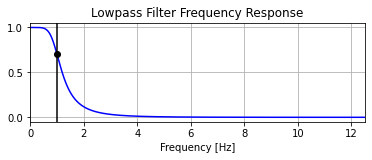

In [18]:
cutoff = 1  # desired cutoff frequency of the filter, Hz
fs = 25     # sample rate, Hz
order = 3

plot_butter_lowpass_filter(cutoff, fs, order)
plt.show()

Prepare the dataset with pandas
* split training and test set
* shuffle the dataset

In [19]:

# *** MERGE LABELS
# Merge sit and stand labels
sit_or_stand_filter = (y_df["label"] == "sit") | (y_df["label"] == "stand")
y_df["label"].loc[sit_or_stand_filter] = "no_activity"

# Merge stairs activity
#stairsdown_or_stairsup_filter = (y_df["label"] == "stairsdown") | (y_df["label"] == "stairsup")
#y_df["label"].loc[stairsdown_or_stairsup_filter] = "stairs"

# *** SHUFFLE
X_shuffled_df = X_df.sample(frac=1)
y_shuffled_df = y_df.reindex(X_shuffled_df.index)

# *** TRAIN AND TEST
if USE_BRYAN_VALIDATION_DATASET:
    but_last_user_indicies = ~(y_df['user'] == "z")
else:
    but_last_user_indicies = ~((y_df['user'] == "a") | (y_df['user'] == "b"))

X_train_df = X_shuffled_df.loc[but_last_user_indicies]
X_test_df = X_shuffled_df.loc[~but_last_user_indicies]

y_train_df = y_shuffled_df.loc[but_last_user_indicies]
y_test_df = y_shuffled_df.loc[~but_last_user_indicies]

print("X_train_df =", len(X_train_df))
print("X_test_df =", len(X_test_df))
print("y_train_df =", len(y_train_df))
print("y_test_df =", len(y_test_df))

assert len(X_train_df) == len(y_train_df), "X train and y train do not contain same number of samples"
assert len(X_test_df) == len(y_test_df), "X test and y test do not contain same number of samples"


X_train_df = 46657
X_test_df = 0
y_train_df = 46657
y_test_df = 0


Preprocess dataset

In [20]:
# Preprocess and prepare training and test set
X_train, y_train = get_X(X_train_df), get_y(y_train_df)
X_test, y_test = get_X(X_test_df), get_y(y_test_df)

# Retrieve al
y_train_hot = get_y_hot(y_train_df)
y_test_hot = get_y_hot(y_test_df)

In [21]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(46657, 6, 125)
(46657,)
(0,)
(0,)


Show labels

In [22]:
classes = np.unique(y_train)
num_classes = len(np.unique(y_train))

print(f"Classes = {classes}")
print(f"Num classes = {num_classes}")

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']
Num classes = 5


Plot some samples

X[0]: stairsdown


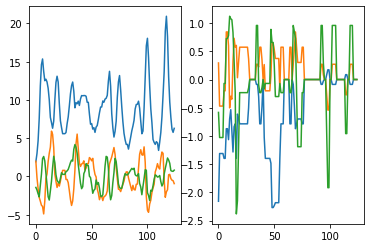

In [23]:
show_samples(X_train, y_train, n=1, is_random=False)

In [24]:
if (len(X_test) > 0):
    show_samples(X_test, y_test, n=1, is_random=False)
else:
    print("WARNING: there is no data in X_test. Are you using Bryan dataset as validation set?")

### Validation Set

Prepare the dataset

In [25]:
X_df, y_df = X_df_reference_validation.copy(), y_df_reference_validation.copy()

# Keep valid positions only
if USE_ALL_POSITION_BRYAN_DATASET:
    valid_positions_indicies = ~(y_df["position"] == "none")
elif USE_ONLY_HAND_POCKET_POSITION_BRYAN_DATASET:
    valid_positions_indicies = (y_df["position"] == "hand") | (y_df["position"] == "pocket-up") | (y_df["position"] == "pocket-down")
else:
    valid_positions_indicies = (y_df["position"] == "right") | (y_df["position"] == "left") | (y_df["position"] == "top") | (y_df["position"] == "back") | (y_df["position"] == "bottom")



# Filter out other data
X_df = X_df.loc[valid_positions_indicies]
y_df = y_df.loc[valid_positions_indicies]

# Shuffle data
X_df = X_df.sample(frac=1)
y_df = y_df.reindex(X_df.index)

Preprocess dataset

In [26]:
X_validation = get_X(X_df)
y_validation = get_y(y_df)
y_validation_hot = get_y_hot(y_df)

In [27]:
X_validation_df = X_df.copy()
y_validation_df = y_df.copy()

del X_df, y_df

In [28]:
print(X_validation.shape)
print(y_validation.shape)
print(y_validation_hot.shape)

(2349, 6, 125)
(2349,)
(2349, 5)


X[0]: no_activity


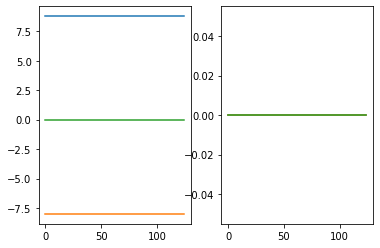

In [29]:
show_samples(X_validation, y_validation, n=1, is_random=False)

In [30]:
if USE_BRYAN_VALIDATION_DATASET :
    X_test = X_validation
    y_test = y_validation
    y_test_hot = y_validation_hot

X[0]: no_activity


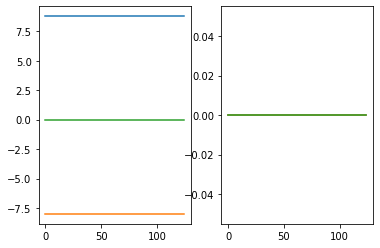

In [31]:
show_samples(X_test, y_test, n=1, is_random=False)

Check size

In [32]:
assert X_train.shape[0] == y_train.shape[0], f"Invalid shape for X_train and y_train: {X_train.shape} != {y_train.shape}"
assert X_test.shape[0] == y_test.shape[0], f"Invalid shape for X_test and y_test: {X_test.shape} != {y_test.shape}"
assert X_test.shape[0] == y_test.shape[0], f"Invalid shape for X_test and y_test: {X_test.shape} != {y_test.shape}"
assert y_train_hot.shape == (y_train.shape[0],num_classes), f"Invalid shape of y_train_hot: {y_train_hot.shape}"
assert y_test_hot.shape == (y_test.shape[0],num_classes), f"Invalid shape of y_test_hot: {y_test_hot.shape}"

## Data Exploration

### Training Set

In [33]:
print("Users", y_train_df["user"].unique())
print("Models", y_train_df["model"].unique())
print("Classes", y_train_df["label"].unique())

Users ['h' 'd' 'b' 'i' 'f' 'e' 'g' 'c' 'a']
Models ['s3_2' 's3mini_1' 'nexus4_2' 's3mini_2' 'nexus4_1' 's3_1']
Classes ['stairsdown' 'no_activity' 'walk' 'bike' 'stairsup']


Fraction of samples per label

In [34]:
print(y_train_df.groupby(["label"])["label"].count() / y_train_df["label"].count())

label
bike           0.135007
no_activity    0.370041
stairsdown     0.118417
stairsup       0.160147
walk           0.216388
Name: label, dtype: float64


Fraction of samples per user

In [35]:
print(y_train_df.groupby(["user"])["user"].count() / y_train_df["user"].count())

user
a    0.110123
b    0.108087
c    0.105558
d    0.109073
e    0.123883
f    0.094155
g    0.114988
h    0.112159
i    0.121975
Name: user, dtype: float64


Fraction of samples per model

In [36]:
print(y_train_df.groupby(["model"])["model"].count() / y_train_df["model"].count())

model
nexus4_1    0.195405
nexus4_2    0.207107
s3_1        0.191740
s3_2        0.199134
s3mini_1    0.198813
s3mini_2    0.007802
Name: model, dtype: float64


Number of samples per user i and fraction of samples per class for user i

In [37]:
y_df_i = y_train_df.loc[y_train_df["user"] == "i"]

num_samples_i = y_df_i["label"].count()
fraction_of_samples_per_class_i = y_df_i.groupby(["label"])["label"].count() / y_df_i["label"].count()

print(num_samples_i)
print(fraction_of_samples_per_class_i)

5691
label
bike           0.164119
no_activity    0.370058
stairsdown     0.128976
stairsup       0.109823
walk           0.227025
Name: label, dtype: float64


### Validation Set

In [38]:
print("Classes (validation)", y_validation_df["label"].unique())

Classes (validation) ['no_activity' 'bike' 'stairsup' 'stairsdown' 'walk']


In [39]:
print(y_validation_df.groupby(["label"])["label"].count() / y_validation_df["label"].count())

label
bike           0.264794
no_activity    0.252448
stairsdown     0.106854
stairsup       0.111111
walk           0.264794
Name: label, dtype: float64


In [40]:
print(y_validation_df.groupby(["user"])["user"].count() / y_validation_df["user"].count())

user
a    1.0
Name: user, dtype: float64


In [41]:
print(y_validation_df.groupby(["model"])["model"].count() / y_validation_df["model"].count())

model
oneplus_8t    1.0
Name: model, dtype: float64


## Model (autoencoder)

In [42]:
DATA_SHAPE = X_train.shape[1:]
CODE_SIZE=36

In [43]:
def build_encoder(data_shape, code_size):
    inputs = tf.keras.Input(data_shape)

    X = inputs    
    X = layers.Flatten()(X)
    X = layers.Dense(150, activation="relu")(X)
    X = layers.Dense(code_size, activation="sigmoid")(X)
    outputs = X
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [44]:

def build_decoder(data_shape, code_size):
    inputs = tf.keras.Input((code_size,))

    X = inputs
    X = layers.Dense(150, activation="relu")(X)
    X = layers.Dense(np.prod(data_shape), activation=None)(X)
    outputs = layers.Reshape(data_shape)(X)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [45]:
def build_autoencoder(encoder, decoder):
    inputs = tf.keras.Input(DATA_SHAPE)  # input
    codes = encoder(inputs)              # build the code with the encoder
    outputs = decoder(codes)             # reconstruction the signal with the decoder

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [46]:
encoder = build_encoder(DATA_SHAPE, CODE_SIZE)
decoder = build_decoder(DATA_SHAPE, CODE_SIZE)

In [47]:
autoencoder = build_autoencoder(encoder, decoder)

optimizer = "adam"
loss = "mse"

model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None
epochs=100
batch_size=128

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
save_model_checkpoint_callback = ModelSaveCallback(model_filename)

callbacks = [save_model_checkpoint_callback, early_stopping_callback]

autoencoder.compile(optimizer=optimizer, loss=loss)

history = autoencoder.fit(
    x=X_train, y=X_train, 
    epochs=epochs, 
    validation_data=(X_test, X_test), 
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1)

Epoch 1/100
365/365 [==============================] - 2s 3ms/step - loss: 5.1871 - val_loss: 2.4681
Epoch 2/100
365/365 [==============================] - 1s 3ms/step - loss: 1.4611 - val_loss: 1.3183
Epoch 3/100
365/365 [==============================] - 1s 3ms/step - loss: 1.3122 - val_loss: 1.2270
Epoch 4/100
365/365 [==============================] - 1s 3ms/step - loss: 1.3227 - val_loss: 1.2032
Epoch 5/100
365/365 [==============================] - 1s 3ms/step - loss: 1.3074 - val_loss: 1.2042
Epoch 6/100
365/365 [==============================] - 1s 3ms/step - loss: 1.3094 - val_loss: 1.2000
Epoch 7/100
365/365 [==============================] - 1s 3ms/step - loss: 1.2865 - val_loss: 1.1254
Epoch 8/100
365/365 [==============================] - 1s 3ms/step - loss: 1.1616 - val_loss: 1.0555
Epoch 9/100
365/365 [==============================] - 1s 3ms/step - loss: 1.0662 - val_loss: 1.0396
Epoch 10/100
365/365 [==============================] - 1s 3ms/step - loss: 1.0461 - val_lo

In [48]:
encoder.save("encoder.h5")

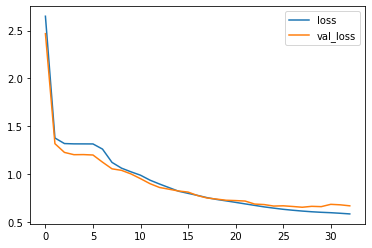

In [49]:
show_loss(history)

In [50]:
show_mse(autoencoder, X_test)

MSE = 0.6687248349189758


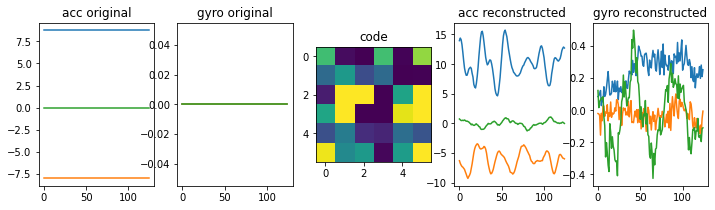

In [51]:
show_reconstructed_signals(X_test, encoder, decoder, n=1)

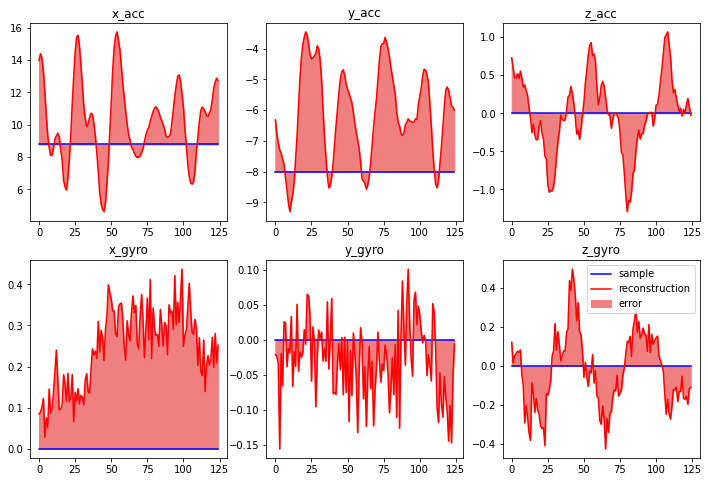

In [52]:
show_reconstruction_errors(X_test, encoder, decoder, n=1)

## KNN classifier

In [53]:
from sklearn.neighbors import KNeighborsClassifier

# prepare the codes
codes = encoder.predict(X_train)

assert codes.shape[1:] == (CODE_SIZE,), f"Predicted codes shape must be equal to code size, but {codes.shape[1:]} != {(CODE_SIZE,)}"

# create the k-neighbors calssifier
n_neighbors = 5
metric = "euclidean"

nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

# fit the model using the codes
nbrs.fit(codes, y_train)

KNeighborsClassifier(metric='euclidean')

In [54]:
print("Classes =", nbrs.classes_)

Classes = ['bike' 'no_activity' 'stairsdown' 'stairsup' 'walk']


In [55]:
print("X_test[i] = y_true \t y_pred    \t with probs [...]")
print()

for i in range(20):
    x = X_test[i]
    y = y_test[i]

    c = encoder.predict(x[np.newaxis, :])[0]
    
    [lab] = nbrs.predict(c[np.newaxis, :])
    [probs] = nbrs.predict_proba(c[np.newaxis, :])

    print(f"X_test[{i}] = {y}\t {lab}   \t with probs {probs}")


X_test[i] = y_true 	 y_pred    	 with probs [...]

X_test[0] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[1] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[2] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[3] = stairsup	 stairsup   	 with probs [0. 0. 0. 1. 0.]
X_test[4] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[5] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[6] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test[7] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[8] = stairsdown	 stairsdown   	 with probs [0. 0. 1. 0. 0.]
X_test[9] = stairsup	 stairsup   	 with probs [0.  0.  0.4 0.6 0. ]
X_test[10] = stairsup	 stairsdown   	 with probs [0.  0.  0.8 0.2 0. ]
X_test[11] = walk	 stairsup   	 with probs [0.2 0.  0.  0.6 0.2]
X_test[12] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[13] = bike	 bike   	 with probs [1. 0. 0. 0. 0.]
X_test[14] = no_activity	 no_activity   	 with probs [0. 1. 0. 0. 0.]
X_test

In [56]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

codes = encoder.predict(X_test)

y_true = y_test
y_pred = nbrs.predict(codes)

f1 = f1_score(y_true=y_true, y_pred=y_pred, average="weighted")
p = precision_score(y_true=y_true, y_pred=y_pred, average="weighted")
r = recall_score(y_true=y_true, y_pred=y_pred, average="weighted")

print(classification_report(y_true=y_true, y_pred=y_pred))
print(f"f1_score = {f1}")
print(f"precision = {p}")
print(f"recall = {r}")

              precision    recall  f1-score   support

        bike       0.75      0.97      0.84       622
 no_activity       0.98      0.99      0.98       593
  stairsdown       0.86      0.89      0.87       251
    stairsup       0.50      0.87      0.63       261
        walk       0.98      0.36      0.53       622

    accuracy                           0.79      2349
   macro avg       0.81      0.82      0.77      2349
weighted avg       0.85      0.79      0.78      2349

f1_score = 0.7751064501960911
precision = 0.8526008298897225
recall = 0.7935291613452533


Grid search for KNN

In [57]:
if USE_KNN_GRID_SEARCH:
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

    results = pd.DataFrame()

    codes_train = encoder.predict(X_train)
    codes_test = encoder.predict(X_test)
    y_true = y_test

    for metric in ["euclidean", "manhattan", "chebyshev", "minkowski", "seuclidean", "mahalanobis"]:
        for n_neighbors in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 40, 100]:
            print(f"metric={metric}, n_neighbors={n_neighbors}")

            nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

            # fit the model using the codes
            nbrs.fit(codes_train, y_train)

            # predict
            y_pred = nbrs.predict(codes_test)

            a = accuracy_score(y_true=y_true, y_pred=y_pred)
            f1 = f1_score(y_true=y_true, y_pred=y_pred, average="weighted")
            p = precision_score(y_true=y_true, y_pred=y_pred, average="weighted")
            r = recall_score(y_true=y_true, y_pred=y_pred, average="weighted")

            data = [{"metric": metric, "n_neighbors": n_neighbors, "accuracy": a, "f1": f1, "precision": p, "recall": r }]
            results = results.append(pd.DataFrame(data), ignore_index=True)

In [58]:
if USE_KNN_GRID_SEARCH:
    rr = results.loc[(results["n_neighbors"] >= 3) & (results["n_neighbors"] <= 8)]
    rr = rr.groupby("metric")["accuracy"].max()
    print(rr)
    print(rr.max())

    results.to_csv("./models/knn_grid_search2.csv")

## KMeans classifier

In [61]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import numpy as np

le = LabelEncoder()
le.fit(y_test)

# train
codes = encoder.predict(X_train)

kmeans = KMeans(n_clusters=num_classes, random_state=0)
kmeans.fit(codes)

# evaluate 
codes = encoder.predict(X_test)

y_true = y_test
y_pred = le.inverse_transform(kmeans.predict(codes))

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

        bike       0.00      0.00      0.00       622
 no_activity       0.00      0.00      0.00       593
  stairsdown       0.14      0.80      0.23       251
    stairsup       0.15      0.25      0.18       261
        walk       0.00      0.00      0.00       622

    accuracy                           0.11      2349
   macro avg       0.06      0.21      0.08      2349
weighted avg       0.03      0.11      0.05      2349



## NN classifier

In [58]:
def build_nn(code_size):
    inputs = tf.keras.Input((code_size,))
    X = inputs
    X = layers.Dense(100, activation="relu")(X)
    X = layers.Dropout(0.1)(X)
    X = layers.Dense(100, activation="relu")(X)
    X = layers.Dropout(0.1)(X)
    X = layers.Dense(num_classes, activation="softmax")(X)
    outputs = X

    return tf.keras.Model(inputs=inputs, outputs=outputs)


codes_train = encoder.predict(X_train)
codes_test = encoder.predict(X_test)

nn_model = build_nn(CODE_SIZE)

adam_optimizer = tf.keras.optimizers.Adam()
loss_funct = tf.keras.losses.CategoricalCrossentropy()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
callbacks = [early_stopping_callback]

nn_model.compile(optimizer=adam_optimizer, loss=loss_funct, metrics=["accuracy"])
nn_model.summary()

history = nn_model.fit(x=codes_train, y=y_train_hot,
    epochs=50,
    validation_data=(codes_test, y_test_hot), 
    batch_size=128,
    callbacks=callbacks,
    verbose=1)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 36)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               3700      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 14,305
Trainable params: 14,305
Non-trainable params: 0
_______________________________________________________

In [ ]:
from sklearn.metrics import accuracy_score

loss, accuracy = nn_model.evaluate(codes_test, y_test_hot)

print("LOSS =", loss)
print("ACCURACY =", accuracy)

show_loss(history)

# Grid Search


We are searching for best hyperparams. More precisely we want to find the best autoencoder model given

* code size
* optimizer
* loss func
* epochs
* batch size

In [60]:
def get_filename(hparams):
    return f'models/encoder{get_settings()}_cs-{hparams["code_size"]}_loss-{hparams["loss_func"]}_bs-{hparams["batch_size"]}.h5'

def compile_autoencoder(autoencoder, hparams):
    """
    Compile autoencoder with given hyperparams.
    """

    optimizer = hparams["optimizer"]
    loss = hparams["loss_func"]

    autoencoder.compile(optimizer=optimizer, loss=loss)

    return autoencoder


def fit_autoencoder(autoencoder, hparams):
    """
    Fit the autoencoder with given hyperparams on `X_train` with validation `X_test`.
    Please note that the best and last models are saved in `models` folder.
    """

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    callbacks = [early_stopping_callback]

    history = autoencoder.fit(
        x=X_train, y=X_train, 
        epochs=hparams["epochs"], 
        validation_data=(X_test, X_test), 
        batch_size=hparams["batch_size"],
        callbacks=callbacks,
        verbose=0)

    return history


def evaluate_autoencoder(autoencoder):
    """
    Evaluate the autoencoder with `X_test`.
    """
    return autoencoder.evaluate(X_test, X_test, verbose=0)


def run_model(hparams):
    """
    Setup, train and evaluate the autoencoder model with given hyperparams.

    :return: A tuple `(loss, hystory)`
    """
    encoder = build_encoder(DATA_SHAPE, hparams["code_size"])
    decoder = build_decoder(DATA_SHAPE, hparams["code_size"])

    autoencoder = build_autoencoder(encoder, decoder)
    autoencoder = compile_autoencoder(autoencoder, hparams)

    history = fit_autoencoder(autoencoder, hparams)
    loss = evaluate_autoencoder(autoencoder)

    # Note: we may also add the classifier training and evaluation 
    #       to select the best model

    filepath = get_filename(hparams)
    encoder.save(filepath)

    return loss, history


def select_model():
    """
    Run the model with hyperparams and save results.

    :return: An array of results with mse, hparams and training history.
    """
    results = []

    hparams_code_sizes = [2, 3, 4, 5, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 72]
    hparams_opts = ["adam"]
    hparams_losses = ["mse"]
    hparams_epochs = [150]
    hparams_batch_sizes = [32, 128]

    n_iterations = np.prod([len(hparams_code_sizes), len(hparams_opts), len(hparams_losses), len(hparams_epochs), len(hparams_batch_sizes)])

    print(f"Starting model selection... {n_iterations} iterations needed.") 

    for code_size in hparams_code_sizes:
        for opt in hparams_opts:
            for loss in hparams_losses:
                for epochs in hparams_epochs:
                    for batch_size in hparams_batch_sizes:

                        hparams = {
                            "code_size": code_size,
                            "optimizer": opt,
                            "loss_func": loss,
                            "epochs": epochs,
                            "batch_size": batch_size
                        }

                        print(f"Starting run {len(results)}")
                    
                        loss_val, history = run_model(hparams)

                        print(f"hparams = {hparams}")
                        print(f"{loss} = {loss_val}")
                        print()

                        results += [{"hparams": hparams, "loss_val": loss_val, "history": history}]

    return results

Select the best model based on lowest loss.

In [61]:
import time

results = []

if USE_GRID_SEARCH:
    start = time.time()
    results = select_model()
    end = time.time()

    print(f"Done in {end - start} s")

Print a CSV table for models and save them to file

In [62]:
def get_csv(results):
    if ():
        return ""
    
    s = ",".join(["i", "type", "loss_val"] + [k for k,_ in results[0]["hparams"].items()] + ["filepath"]) + "\n"
    
    for i, result in zip(range(len(results)), results):
        hparams = result["hparams"]
        code_size = hparams["code_size"]
        batch_size = hparams["batch_size"]
        loss_val = result["loss_val"]

        filepath = get_filename(hparams)
        type = get_settings().lstrip("_") if get_settings() != "" else "default"

        s += ",".join([str(i), type, str(loss_val)] + [str(v) for _,v in hparams.items()] + [filepath]) + "\n"
    
    return s


def save_results(results, filename=f'models/res{get_settings()}.csv'):
    with open(filename, mode="w+") as f:
        content = get_csv(results)
        f.write(content)

if len(results) > 0:
    print(get_csv(results))

    if USE_GRID_SEARCH:
        save_results(results)
    else:
        print("WARNING: Results were not saved to file.")

Check best model

In [63]:
def test_best_model(best_filename, code_size):
    
    def run_nn(codes_train, codes_test):
        nn_model = build_nn(code_size)

        adam_optimizer = tf.keras.optimizers.Adam()
        loss_funct = tf.keras.losses.CategoricalCrossentropy()

        early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        callbacks = [early_stopping_callback]

        nn_model.compile(optimizer=adam_optimizer, loss=loss_funct, metrics=["accuracy"])
        #nn_model.summary()

        history = nn_model.fit(x=codes_train, y=y_train_hot,
            epochs=100,
            validation_data=(codes_test, y_test_hot), 
            batch_size=128,
            callbacks=callbacks,
            verbose=0)

        loss, accuracy = nn_model.evaluate(codes_test, y_test_hot)

        return accuracy, loss

        #show_loss(history)
    

    def run_knn(codes_train, codes_test):
        from sklearn.neighbors import KNeighborsClassifier

        # create the k-neighbors calssifier
        n_neighbors = num_classes
        metric = "euclidean"

        nbrs = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)

        # fit the model using the codes
        nbrs.fit(codes_train, y_train)

        from sklearn.metrics import mean_squared_error
        from sklearn.metrics import accuracy_score

        y_true = y_test
        y_pred = nbrs.predict(codes_test)

        #loss = mean_squared_error(y_true=y_true, y_pred=y_pred)
        accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)

        return accuracy


    encoder = tf.keras.models.load_model(best_filename, compile=False)
    encoder.compile(optimizer="adam", loss="mse")

    codes_train = encoder.predict(X_train, verbose=0)
    codes_test = encoder.predict(X_test, verbose=0)

    accuracy_knn = run_knn(codes_train, codes_test)
    accuracy_nn, loss_nn = run_nn(codes_train, codes_test)

    return {"accuracy_knn": accuracy_knn, "accuracy_nn": accuracy_nn, "loss_nn": loss_nn }
    

if USE_GRID_SEARCH_VALIDATION:
    validations_df = pd.DataFrame(columns=["accuracy_knn", "accuracy_nn", "loss_nn"])

    res_df = pd.read_csv(f"models/res{get_settings()}.csv")
    #res_oit_df = pd.read_csv("./models/res_oit.csv.txt")

    #data_df = res_df.append(res_oit_df, ignore_index=True)
    data_df = res_df
    
    for index, row in data_df.iterrows():
        print(f"Validating model {index} ({row['filepath']})")

        test_res = test_best_model(row["filepath"], row["code_size"])

        validations_df = validations_df.append(pd.DataFrame([{ **{"filepath": row['filepath']}, **test_res }]), ignore_index=True)
    
    print(validations_df)

    validations_df.to_csv(f"./models/validation{get_settings()}.csv")
    print("Done")

In [64]:
fn = "models/manual/encoder_oit_bryan_allpos_cs-30_bs-128.h5"
print(test_best_model(fn, 30))

77/77 [==============================] - 0s 695us/step - loss: 0.5575 - accuracy: 0.7751
{'accuracy_knn': 0.8635804997951659, 'accuracy_nn': 0.7750921845436096, 'loss_nn': 0.5574924945831299}
